> In this second notebook, the aim is to analyse the 6 datasets in csv format and generate meaningful insights form them.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

### Global Monthly Mean Surface Temperature Change

This csv file on Global Monthly Mean Surface Temperature Change provides on a monthly basis, the global mean surface temperature anomaly from 1880.04 to the present (in celsius).

In [2]:
GMMST = pd.read_csv("./Global Monthly Mean Surface Temperature Change.csv")

df1 = GMMST

# Convert "time" column from object to float
df1['time'] = df1['time'].astype(float)

# Create a new column "year" by applying math.floor to "time" column
df1['year'] = df1['time'].apply(lambda x: math.floor(x))

df1['month'] = (df1['time'].apply(lambda x: int(str(x).split('.')[1]))/100)*12
df1['month'] = df1['month'].astype(int)
df1['month'] = df1['month'].apply(lambda x: x + 1)

# # drop the time column since we have replaced its format
# df1 = df1.drop('time', axis=1)

# reorder the columns 
df1 = df1.reindex(columns=['year', 'month', 'station', 'land'])

# merge year and month columns into a date column
# df1['date'] = pd.to_datetime(df1[['year', 'month']].assign(day=1))
# df1['year_month'] = df1['date'].dt.strftime('%Y-%m')
# df1['year_month'] = pd.to_datetime(df1['year_month'])
# drop the original year and month columns
# df = df.drop(['year', 'month'], axis=1)

# print the updated dataframe
print(df1.tail(5))
df1.describe()
# check missing values
# df1.isnull().sum()
# GMMST= df1[['year_month', 'station', 'land']]
# # GMMST.set_index('year_month', inplace=True)

# # print the updated dataframe
# GMMST.head()

# The global mean surface temperature anomaly from the station and from the land have been increasing over time.
# There is a difference between the temperature anomalies from the station and from the land.

      year  month  station  land
1713  2022     10     1.30  0.97
1714  2022     11     0.95  0.73
1715  2022     12     1.08  0.79
1716  2023      1     1.15  0.86
1717  2023      2     1.28  0.97


,year,month,station,land
count,1718.000000,1718.000000,1718.000000,1718.000000
mean,1951.083818,6.494179,0.092130,0.061601
std,41.340525,3.455301,0.482458,0.382381
min,1880.000000,1.000000,-1.440000,-0.810000
25%,1915.000000,3.000000,-0.230000,-0.220000
50%,1951.000000,6.000000,-0.020000,-0.030000
75%,1987.000000,9.000000,0.330000,0.280000
max,2023.000000,12.000000,1.710000,1.370000


The describe method of the pandas DataFrame gives an overview of the distribution of the numerical columns of the DataFrame. For df1, we can see that there are 1718 rows and 4 columns. The 'year' column ranges from 1880 to 2023, while the 'month' column ranges from 1 to 12. The 'station', 'land' columns seem to have mean values close to 0, with standard deviations of 0.48 and 0.38, respectively. The 'station' and 'land' columns have minimum and maximum values of -1.44 and 1.37, respectively. The 25th, 50th, and 75th percentile values for 'station' are -0.23, -0.02, and 0.33, respectively, while the corresponding values for 'land' are -0.22, -0.03, and 0.28, respectively.

<div class="alert alert-block alert-light">
<b>Overall, </b>the 'station' and 'land' columns seem to have similar ranges and distributions. The 'year' and 'month' columns, on the other hand, are categorical variables and should be treated as such.</div>

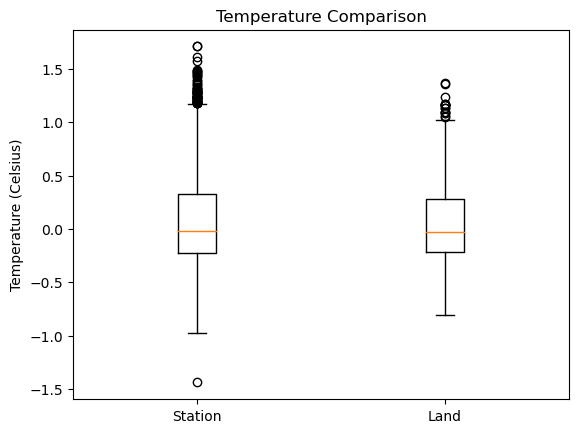

In [3]:
# Create the box plot to identify outliers in the two columns station and land.
# Create a figure and axis object
fig, ax = plt.subplots()

# Create box plots
station_temps = df1['station'].values
land_temps = df1['land'].values
data = [station_temps, land_temps]
ax.boxplot(data)

# Set x and y axis labels and title
ax.set_xticklabels(['Station', 'Land'])
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Comparison')

# Show the plot
plt.show()


Skewness: 0.792131
Kurtosis: 0.227035


C:\Users\aa_ab\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


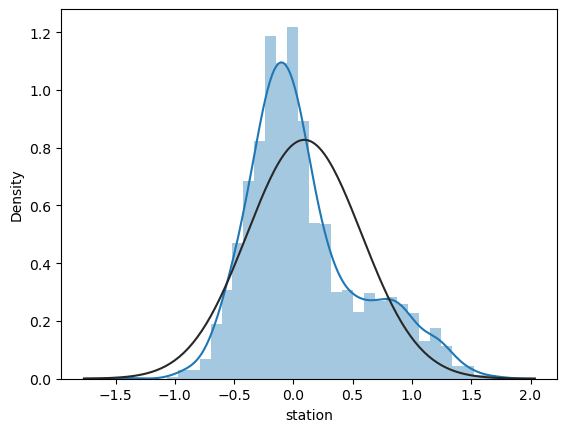

In [4]:
print("Skewness: %f" % df1['station'].skew())
print("Kurtosis: %f" % df1['station'].kurt())

plt.figure()
sns.distplot(df1['station'], kde=True, fit=norm)
plt.show()

Using a box plot, its possible to get an insight into the 'station' and 'land' columns in the df1 dataframe. There is a significant amount of data points that are outliers in both columns with only the station having an outliers both above  and below and land only above the expected range.

For the next approach, handling the outliers to ensure a more accurate representation of the data with less noise interfereing with the interpretablility of the data

In [5]:
attr = 'station'
quartile1 = df1[attr].quantile(0.25)
quartile3 = df1[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df1[df1[attr] <= low_limit])
df1[df1[attr] >= up_limit].count()

     year  month  station  land
156  1893      1    -1.44 -0.81


year       59
month      59
station    59
land       59
dtype: int64

The station column has a total of 60 outliers. These will be replaced with the lower and upper limits from quartile computation in the previous cell.

Skewness: 0.690051
Kurtosis: -0.154455


C:\Users\aa_ab\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


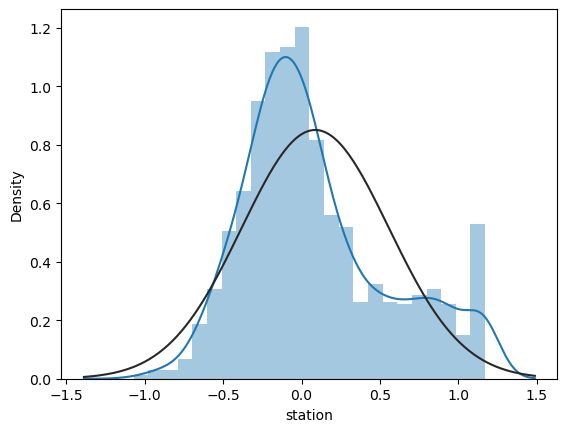

In [6]:
df1.loc[(df1[attr] < low_limit), attr] = low_limit
df1.loc[(df1[attr] > up_limit), attr] = up_limit


print("Skewness: %f" % df1['station'].skew())
print("Kurtosis: %f" % df1['station'].kurt())

plt.figure()
sns.distplot(df1['station'], kde=True, fit=norm)
plt.show()

The same approach is then applied to the land column

Skewness: 0.773445
Kurtosis: -0.006301


C:\Users\aa_ab\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


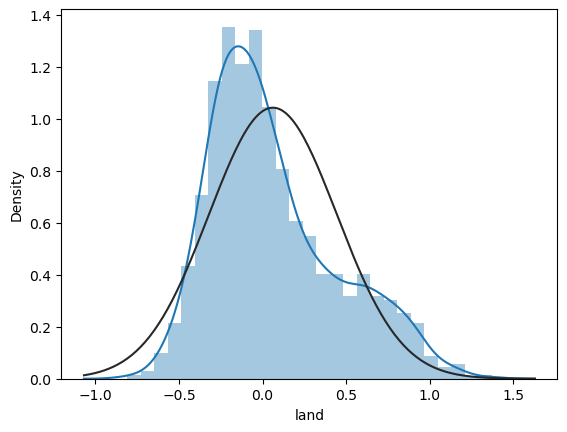

In [7]:
print("Skewness: %f" % df1['land'].skew())
print("Kurtosis: %f" % df1['land'].kurt())

plt.figure()
sns.distplot(df1['land'], kde=True, fit=norm)
plt.show()

In [8]:
attr = 'land'
quartile1 = df1[attr].quantile(0.25)
quartile3 = df1[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df1[df1[attr] <= low_limit].count())
df1[df1[attr] >= up_limit].count()

year       0
month      0
station    0
land       0
dtype: int64


year       17
month      17
station    17
land       17
dtype: int64

Skewness: 0.725515
Kurtosis: -0.186009


C:\Users\aa_ab\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


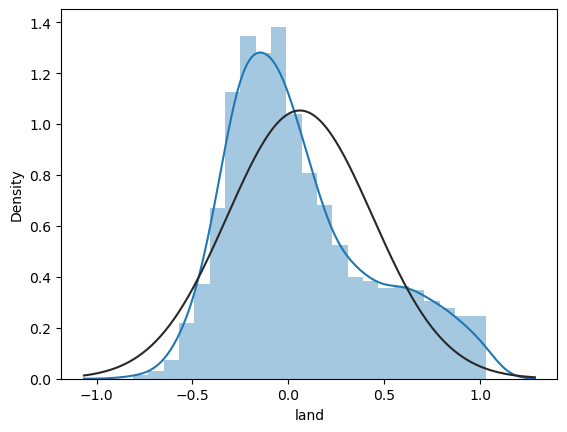

In [9]:
df1.loc[(df1[attr] > up_limit), attr] = up_limit


print("Skewness: %f" % df1['land'].skew())
print("Kurtosis: %f" % df1['land'].kurt())

plt.figure()
sns.distplot(df1['land'], kde=True, fit=norm)
plt.show()

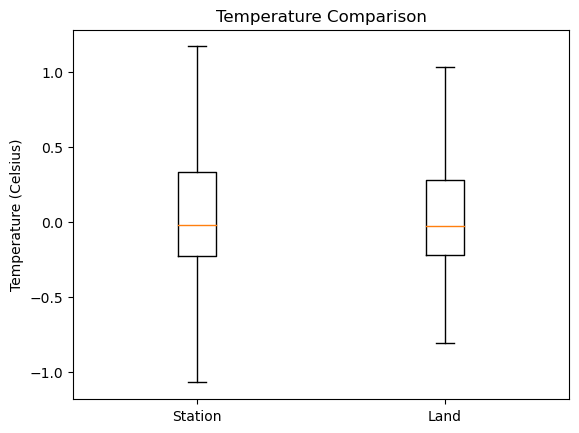

In [10]:
fig, ax = plt.subplots()

# Create box plots
station_temps = df1['station'].values
land_temps = df1['land'].values
data = [station_temps, land_temps]
ax.boxplot(data)

# Set x and y axis labels and title
ax.set_xticklabels(['Station', 'Land'])
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Comparison')

# Show the plot
plt.show()

From the box plot above and the distribution graphs, the visuals show data that has minimal noise and clear insights can now be extracted from this data

In [11]:
df1[['station', 'land']].max()

station    1.17
land       1.03
dtype: float64

In [12]:
df1[['station', 'land']].min()

station   -1.07
land      -0.81
dtype: float64

In [13]:
df1[['station', 'land']].describe()

,station,land
count,1718.000000,1718.000000
mean,0.087346,0.060326
std,0.469144,0.378817
min,-1.070000,-0.810000
25%,-0.230000,-0.220000
50%,-0.020000,-0.030000
75%,0.330000,0.280000
max,1.170000,1.030000


From the above cells, station and land both have a variation in values and it is evident from the data that on average the station has slightly higher temperatures than the land readings but also has the lowest temperature reading in comparison to the land readings recorded.

The Chart below will show the temperatures from both the station and land over the years.

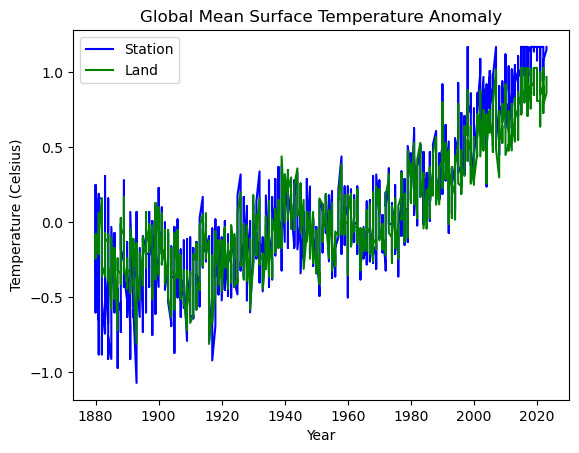

In [14]:
# create a figure and axis object with subplots
fig, ax = plt.subplots()

# plot the station temperature as a blue line
ax.plot(df1['year'], df1['station'], color='blue', label='Station')

# plot the land temperature as a green line
ax.plot(df1['year'], df1['land'], color='green', label='Land')

# set the title, x-label, and y-label
ax.set_title('Global Mean Surface Temperature Anomaly')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (Celsius)')

# add a legend to the plot
ax.legend()

# display the plot
plt.show()

From the above chart we can see that in general; temperature reading for both the station and land have increased over time and have risen by over 1 degree celsius, though is also clear that temperatures from the station are more volatile in distribution in comparison to the land readings 

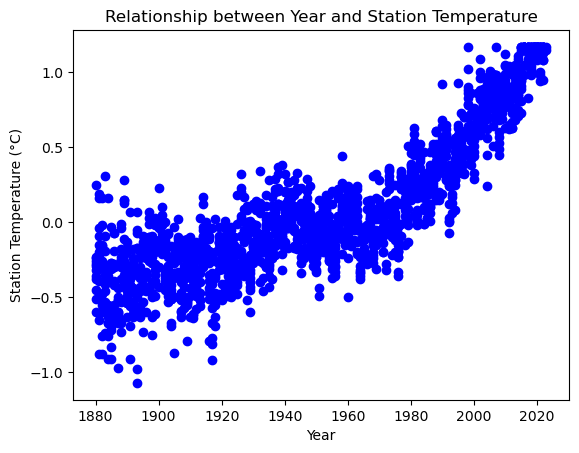

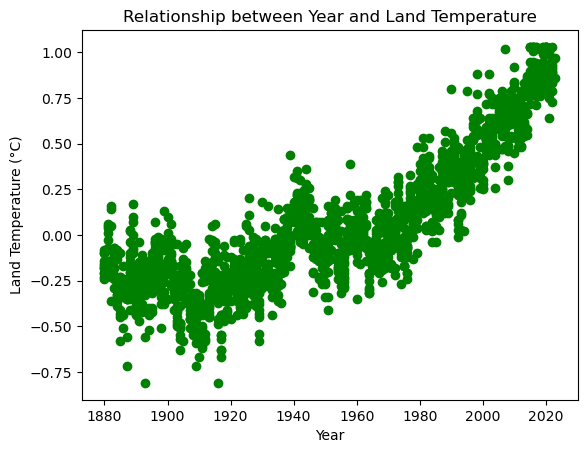

In [15]:
# scatter plot for station temperature
plt.scatter(df1['year'], df1['station'], color='blue')
plt.xlabel('Year')
plt.ylabel('Station Temperature (°C)')
plt.title('Relationship between Year and Station Temperature')

# scatter plot for land temperature
plt.figure()
plt.scatter(df1['year'], df1['land'], color='green')
plt.xlabel('Year')
plt.ylabel('Land Temperature (°C)')
plt.title('Relationship between Year and Land Temperature')

plt.show()

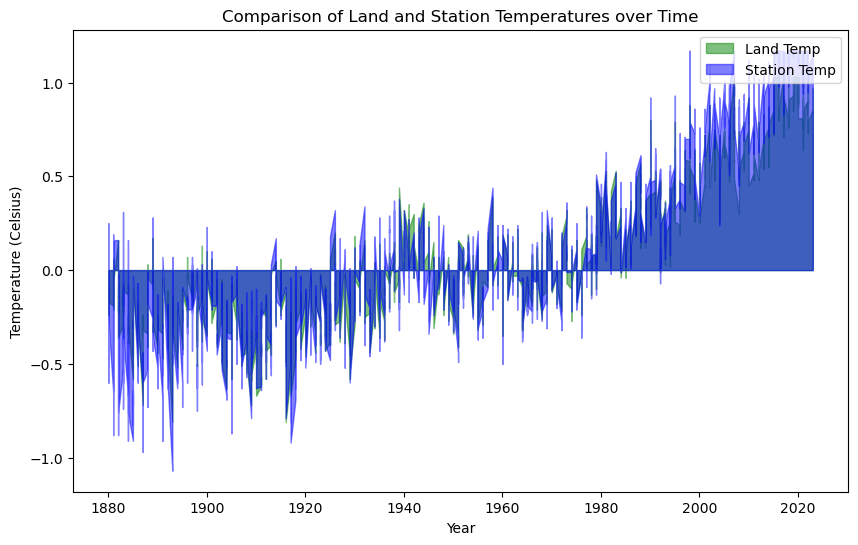

In [16]:
# create a figure and axis objects
fig, ax = plt.subplots(figsize=(10,6))

# plot the area chart for land temperature
ax.fill_between(df1['year'], 0, df1['land'], alpha=0.5, color='green', label='Land Temp')

# plot the area chart for station temperature
ax.fill_between(df1['year'], 0, df1['station'], alpha=0.5, color='blue', label='Station Temp')

# set the x and y labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Comparison of Land and Station Temperatures over Time')

# set the legend
ax.legend()

# show the plot
plt.show()

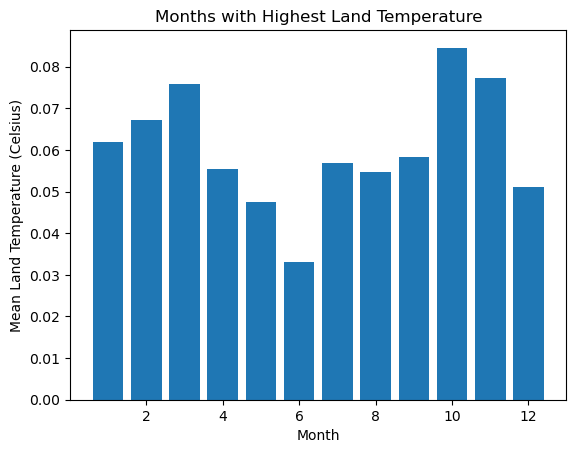

In [17]:
# Group the data by month and calculate the mean land temperature
monthly_mean = df1.groupby('month')['land'].mean()

# Sort the values in descending order
monthly_mean = monthly_mean.sort_values(ascending=False)

# Create the bar chart
plt.bar(monthly_mean.index, monthly_mean.values)

# Set the axis labels and title
plt.xlabel('Month')
plt.ylabel('Mean Land Temperature (Celsius)')
plt.title('Months with Highest Land Temperature')
plt.show()

From this distribution of the mean land temperatures with a focus on the months, its conclusive that the lowest temperatures are recorded in June and the highest in October. Is this the same for the station readings?

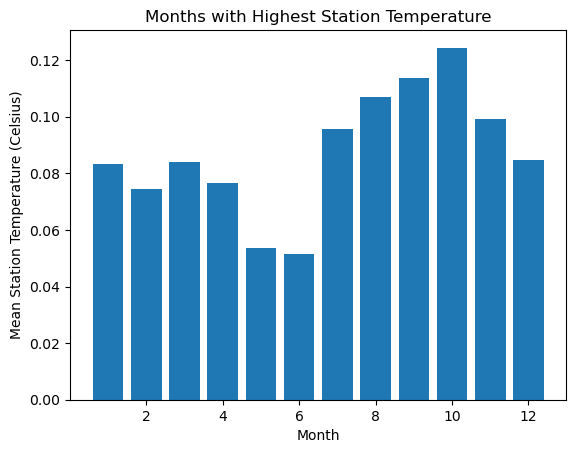

In [18]:
# Group the data by month and calculate the mean land temperature
monthly_mean = df1.groupby('month')['station'].mean()

# Sort the values in descending order
monthly_mean = monthly_mean.sort_values(ascending=False)

# Create the bar chart
plt.bar(monthly_mean.index, monthly_mean.values)

# Set the axis labels and title
plt.xlabel('Month')
plt.ylabel('Mean Station Temperature (Celsius)')
plt.title('Months with Highest Station Temperature')
plt.show()

From this chart, Station temperatures are lowest in June as well but May is significantly close to matching with June which isnt the case for the Land readings. The station and land readings also agree with the maximum temperature readings being in October though much higher in the station readings.

In conclusion, the station temperatures are much higher in general to the land temperatures.

### Daily global seasonal cycle and trend value

In [19]:
DGSCTV = pd.read_csv('./Daily global seasonal cycle and trend value.csv')

df2 = DGSCTV

# assuming df is your dataframe
df2['date'] = pd.to_datetime(df2[['year', 'month', 'day']])

df2.set_index('date', inplace=True)
df2 = df2[['cycle', 'trend']]
print(df2.describe())
df2.head()

# DGSCTV = df2[['date', 'cycle', 'trend']]
# DGSCTV.set_index('date', inplace=True)

# DGSCTV.head()

             cycle        trend
count  3708.000000  3708.000000
mean    406.772209   406.749738
std       7.417399     7.192125
min     392.600000   394.420000
25%     400.317500   399.967500
50%     407.060000   406.805000
75%     413.362500   413.112500
max     420.340000   418.500000


,cycle,trend
date,,
2013-01-20,395.64,394.42
2013-01-21,395.67,394.43
2013-01-22,395.70,394.44
2013-01-23,395.72,394.44
2013-01-24,395.75,394.45


For this dataframe, date column has been indexed to assist with time-based analysis for the dataframe df2.

The below box plot shows no outliers in the two columns 'cycle' and 'trend'.

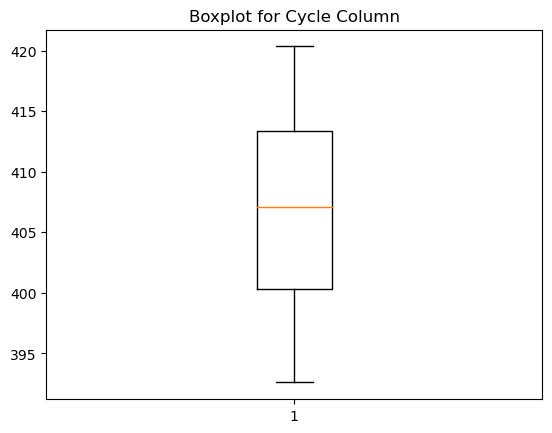

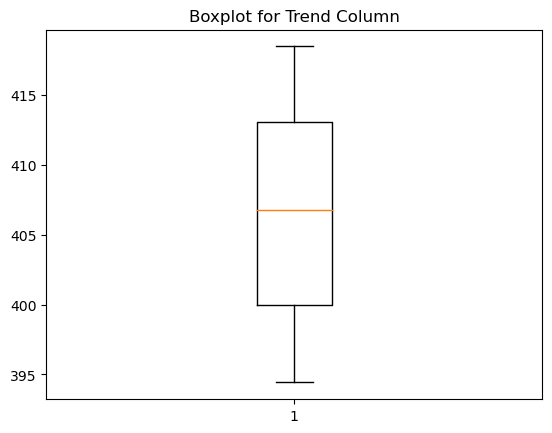

In [20]:
# Boxplot for cycle column
plt.boxplot(df2['cycle'])
plt.title('Boxplot for Cycle Column')
plt.show()

# Boxplot for trend column
plt.boxplot(df2['trend'])
plt.title('Boxplot for Trend Column')
plt.show()

In [21]:
# Calculate the interquartile range for each column
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1

# Detect outliers using the IQR method
outliers = ((df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR))).any(axis=1)

# Print the number of outliers detected
print(f'Number of outliers: {outliers.sum()}')

Number of outliers: 0


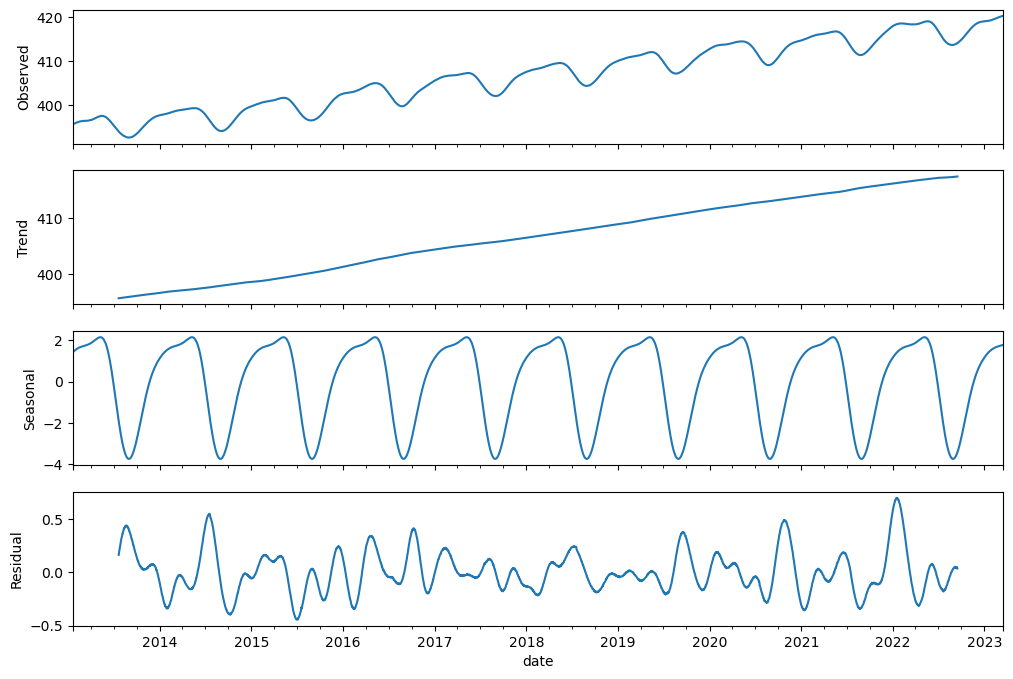

In [22]:
# # convert index to datetime
# df2.index = pd.to_datetime(df2.index)

# perform seasonal decomposition
result_add = seasonal_decompose(df2['cycle'], model='additive', period=365)

# plot the decomposition
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

The first chart(observed) shows the original data for the 'cycle column' The observed component shows the raw data without any trend or seasonal pattern removed, the second chart (trend component) shows the long-term trend in the data, the third chart (seasonal component) shows the cyclic variation in the data, and the fourth chart (residual component) shows the remaining variation in the data that is not explained by the trend or seasonal components. 

The same will be done for the 'trend' column.

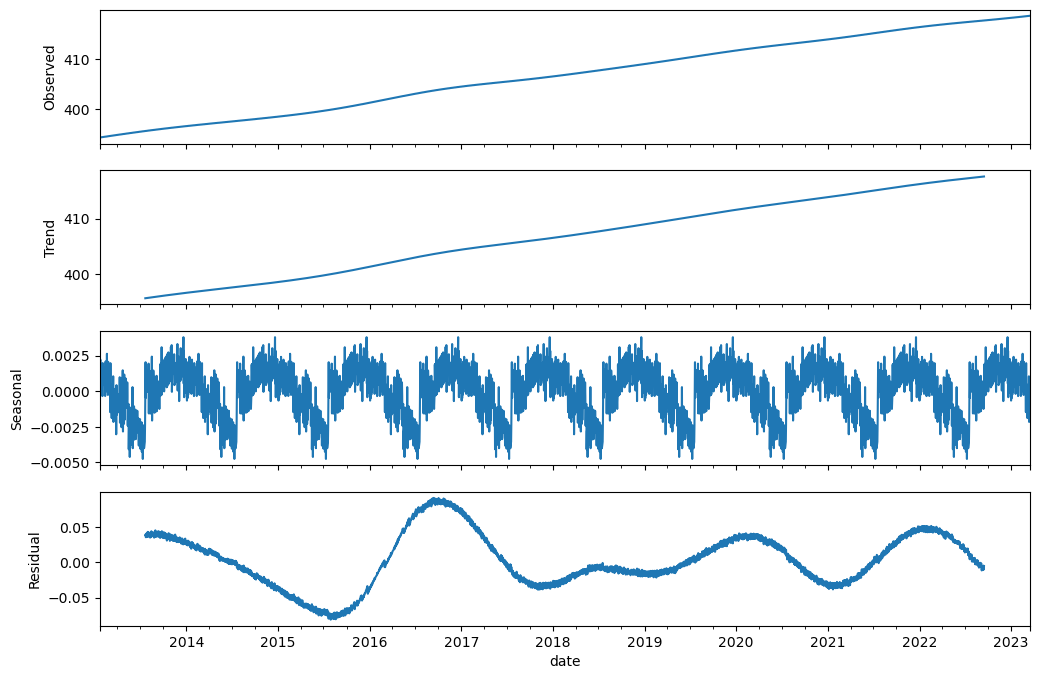

In [23]:
# perform seasonal decomposition
result_add = seasonal_decompose(df2['trend'], model='additive', period=365)

# plot the decomposition
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

This does show that there is an increase in carbon dioxide levels from the observed chart and also that there is a seasonal difference in where by levels drop and rise seasonally.

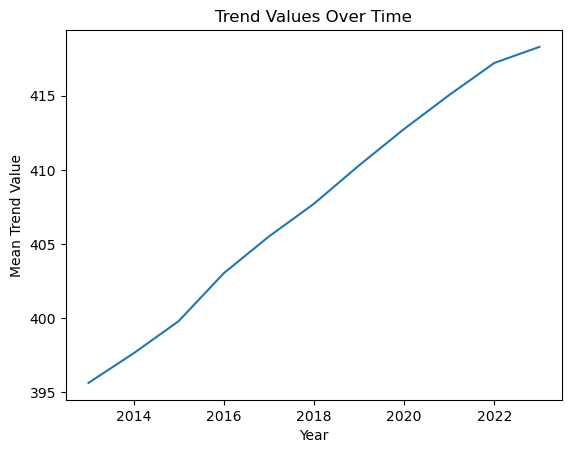

In [24]:
import matplotlib.pyplot as plt

# group the data by year and calculate the mean trend value for each year
df2_yearly = df2.groupby(df2.index.year)['trend'].mean()

# create a line chart
plt.plot(df2_yearly.index, df2_yearly.values)
plt.xlabel('Year')
plt.ylabel('Mean Trend Value')
plt.title('Trend Values Over Time')
plt.show()

<AxesSubplot:>

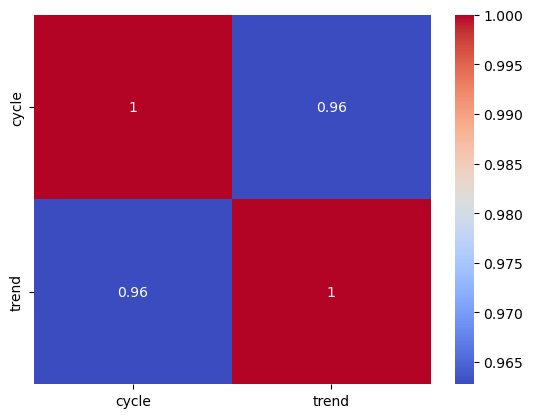

In [25]:
# Compute the correlation matrix
corr_matrix = df2[['cycle','trend']].corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

The above correlation of 1 by 0.96 means that there is a strong positive correlation between the two variables being measured. It suggests that there is a linear relationship between the two variables, and as one variable increases, the other variable also tends to increase. A correlation coefficient of 0.96 indicates a very strong correlation, with a value of 1 indicating a perfect correlation.

### Globally averaged marine surface monthly mean

In [26]:
GAMSMMD = pd.read_csv('./Globally averaged marine surface monthly mean data.csv')

df3 = GAMSMMD
# Drop the repeated row at index 0
df3 = df3.drop(index=0)


df3[['year', 'month']] = df3['date'].astype(str).str.split('.', expand=True)
df3['year'] = df3['year'].astype(int)
df3['month'] = df3['month'].astype(int)

# merge year and month columns into a date column
df3['period'] = pd.to_datetime(df3[['year', 'month']].assign(day=1))
df3['year_month'] = df3['period'].dt.strftime('%Y-%m')
df3[['average', 'trend', 'averageUnc', 'trendUnc']] = df3[['average', 'trend', 'averageUnc', 'trendUnc']].astype(float)
df3.dtypes
df3.isnull().sum()
df3.duplicated().sum()
df3 = df3[['year', 'month', 'average', 'trend', 'averageUnc', 'trendUnc']]

# Details about the dataframe df3
print(df3.describe())
df3.head()
# GAMSMMD = df3[['year_month', 'average', 'trend', 'averageUnc', 'trendUnc']]
# # GAMSMMD.set_index('year_month', inplace=True)

# GAMSMMD.head()

              year       month      average        trend  averageUnc  \
count   473.000000  473.000000   473.000000   473.000000  473.000000   
mean   2002.706131    6.526427  1774.002241  1774.001395    0.798203   
std      11.394147    3.449981    64.312027    64.137928    1.609301   
min    1983.000000    1.000000  1625.920000  1634.890000   -9.990000   
25%    1993.000000    4.000000  1737.400000  1735.650000    0.850000   
50%    2003.000000    7.000000  1774.950000  1774.240000    0.980000   
75%    2013.000000   10.000000  1812.400000  1811.050000    1.150000   
max    2022.000000   12.000000  1923.570000  1916.870000    2.690000   

         trendUnc  
count  473.000000  
mean     0.376956  
std      1.529742  
min     -9.990000  
25%      0.530000  
50%      0.590000  
75%      0.640000  
max      1.390000  


,year,month,average,trend,averageUnc,trendUnc
1,1983,7,1625.92,1634.89,2.10,1.39
2,1983,8,1628.08,1635.47,2.69,1.33
3,1983,9,1638.41,1636.09,2.33,1.27
4,1983,10,1644.73,1636.77,1.59,1.20
5,1983,11,1642.59,1637.51,0.78,1.12


<AxesSubplot:>

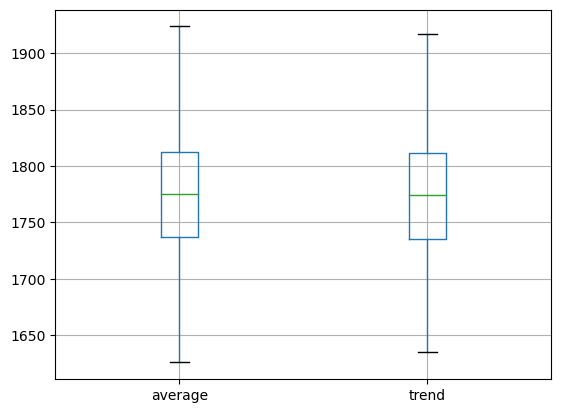

In [27]:
# check for missing values
# df3.replace(to_replace=[-999, -9.99], value=np.nan, inplace=True)
# print('Number of missing values:', df3.isnull().sum().sum())

# check for outliers using box plot
df3.boxplot(column=['average', 'trend'])

# # normalize the data using standard scaler
# scaler = StandardScaler()
# df3[['average', 'trend']] = scaler.fit_transform(df3[['average', 'trend']])


Focusing on the average methane levels column and trend of methane level column we see no outliers. But focus will shift to the other two columns 'averageUnc' and 'trendUnc' that verify the statistical significance of the average and trend columns respectively. 

<AxesSubplot:>

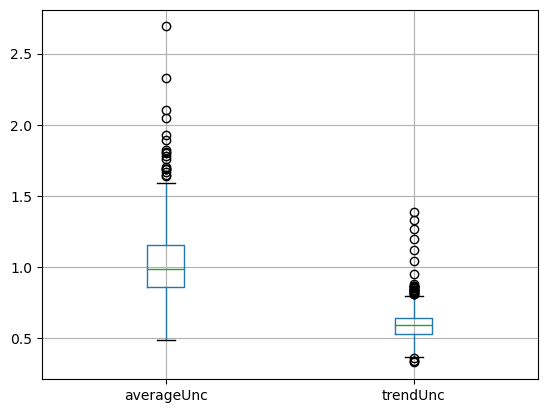

In [28]:
df3[df3[['averageUnc', 'trendUnc']] == -9.99] = np.nan
df3.dropna(inplace=True)
# check for outliers using box plot
df3.boxplot(column=['averageUnc', 'trendUnc'])

There are a significant number of outliers for these two columns and these are data points that are not statistically significant and will be removed.

In [29]:
df3[['averageUnc', 'trendUnc']].describe()

,averageUnc,trendUnc
count,463.000000,463.000000
mean,1.031210,0.600864
std,0.268953,0.119357
min,0.490000,0.330000
25%,0.860000,0.530000
50%,0.990000,0.590000
75%,1.155000,0.640000
max,2.690000,1.390000


In [30]:
attr = 'averageUnc'
quartile1 = df3[attr].quantile(0.25)
quartile3 = df3[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df3[df3[attr] <= low_limit].count())
print(df3[df3[attr] >= up_limit].count())
print(df3.shape)


attr = 'averageUnc'
df3 = df3[df3[attr] < up_limit]
df3.shape

year          0
month         0
average       0
trend         0
averageUnc    0
trendUnc      0
dtype: int64
year          18
month         18
average       18
trend         18
averageUnc    18
trendUnc      18
dtype: int64
(463, 6)


(445, 6)

In [31]:
attr = 'trendUnc'
quartile1 = df3[attr].quantile(0.25)
quartile3 = df3[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df3[df3[attr] <= low_limit].count())
print(df3[df3[attr] >= up_limit].count())
print(df3.shape)


# Drop the outliers from the dataframe
attr = 'trendUnc'
df3 = df3[df3[attr] > low_limit]
df3 = df3[df3[attr] < up_limit]
df3.shape

year          5
month         5
average       5
trend         5
averageUnc    5
trendUnc      5
dtype: int64
year          18
month         18
average       18
trend         18
averageUnc    18
trendUnc      18
dtype: int64
(445, 6)


(422, 6)

Next, check for more outliers from the changes made

<AxesSubplot:>

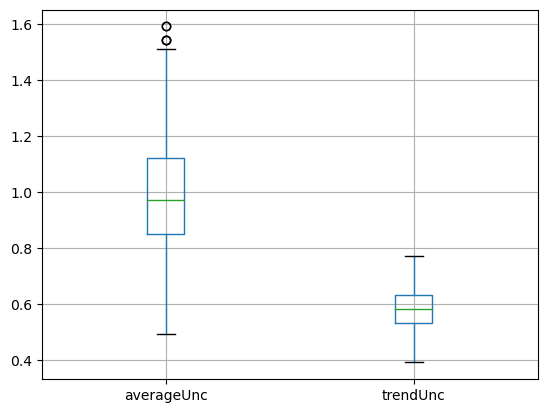

In [32]:
# check for outliers using box plot
df3.boxplot(column=['averageUnc', 'trendUnc'])

Additional outliers exist and should be removed:

In [33]:
attr = 'averageUnc'
quartile1 = df3[attr].quantile(0.25)
quartile3 = df3[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df3[df3[attr] <= low_limit].count())
print(df3[df3[attr] >= up_limit].count())
print(df3.shape)


attr = 'averageUnc'
df3 = df3[df3[attr] < up_limit]
df3.shape

year          0
month         0
average       0
trend         0
averageUnc    0
trendUnc      0
dtype: int64
year          5
month         5
average       5
trend         5
averageUnc    5
trendUnc      5
dtype: int64
(422, 6)


(417, 6)

<AxesSubplot:>

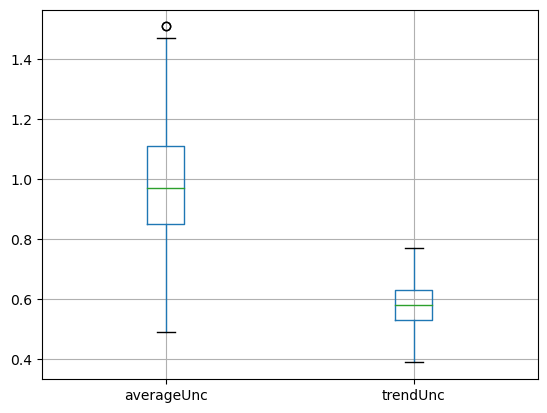

In [34]:
# check for outliers using box plot
df3.boxplot(column=['averageUnc', 'trendUnc'])

In [35]:
attr = 'averageUnc'
quartile1 = df3[attr].quantile(0.25)
quartile3 = df3[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df3[df3[attr] <= low_limit].count())
print(df3[df3[attr] >= up_limit].count())
print(df3.shape)


attr = 'averageUnc'
df3 = df3[df3[attr] < up_limit]
df3.shape

year          0
month         0
average       0
trend         0
averageUnc    0
trendUnc      0
dtype: int64
year          2
month         2
average       2
trend         2
averageUnc    2
trendUnc      2
dtype: int64
(417, 6)


(415, 6)

<AxesSubplot:>

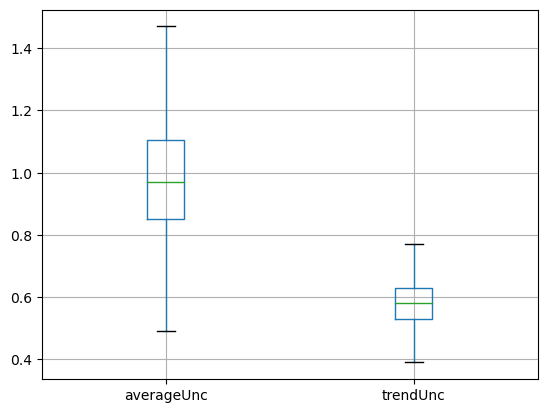

In [36]:
# check for outliers using box plot
df3.boxplot(column=['averageUnc', 'trendUnc'])

In [37]:
df3.describe()

,year,month,average,trend,averageUnc,trendUnc
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,2002.927711,6.460241,1775.660024,1775.541831,0.981759,0.580217
std,10.633989,3.498479,56.842277,56.595132,0.189627,0.072626
min,1984.000000,1.000000,1637.990000,1643.230000,0.490000,0.390000
25%,1994.000000,3.000000,1741.160000,1740.740000,0.850000,0.530000
50%,2003.000000,6.000000,1775.480000,1774.280000,0.970000,0.580000
75%,2012.000000,10.000000,1808.580000,1808.505000,1.105000,0.630000
max,2022.000000,12.000000,1909.730000,1905.620000,1.470000,0.770000


Now the dataframe only holds the significantly relevant records for average and trend columns.

<AxesSubplot:>

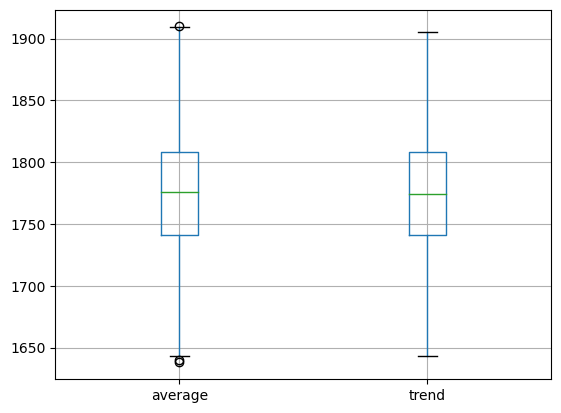

In [38]:
df3.boxplot(column=['average', 'trend'])

Now handle the new outliers for the average column:

year          2
month         2
average       2
trend         2
averageUnc    2
trendUnc      2
dtype: int64
year          1
month         1
average       1
trend         1
averageUnc    1
trendUnc      1
dtype: int64


<AxesSubplot:>

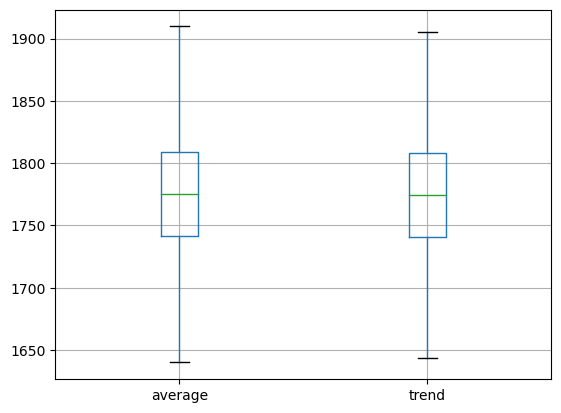

In [39]:
attr = 'average'
quartile1 = df3[attr].quantile(0.25)
quartile3 = df3[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

print(df3[df3[attr] <= low_limit].count())
print(df3[df3[attr] >= up_limit].count())

df3.loc[(df3[attr] < low_limit), attr] = low_limit
df3.loc[(df3[attr] > up_limit), attr] = up_limit
df3.boxplot(column=['average', 'trend'])

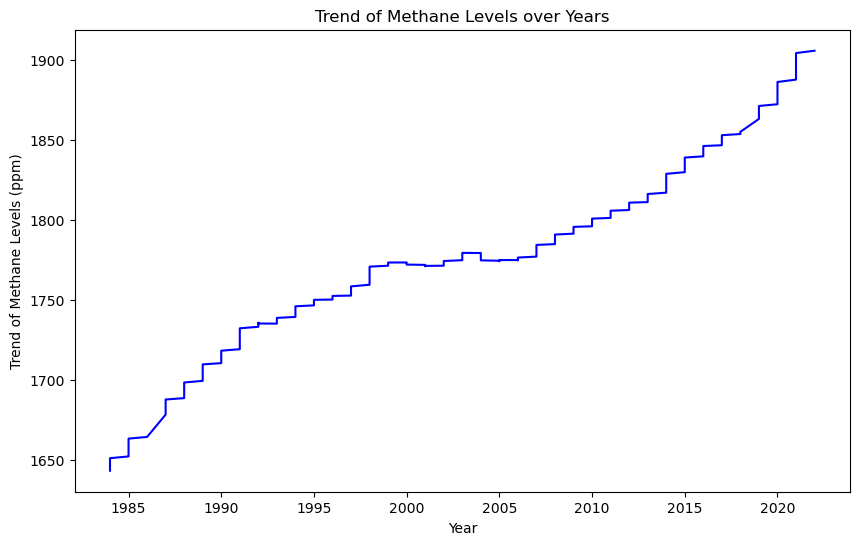

In [40]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# plot the trend of methane levels over years
ax.plot(df3['year'], df3['trend'], color='blue')

# set the title and axis labels
ax.set_title('Trend of Methane Levels over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Trend of Methane Levels (ppm)')

# show the plot
plt.show()

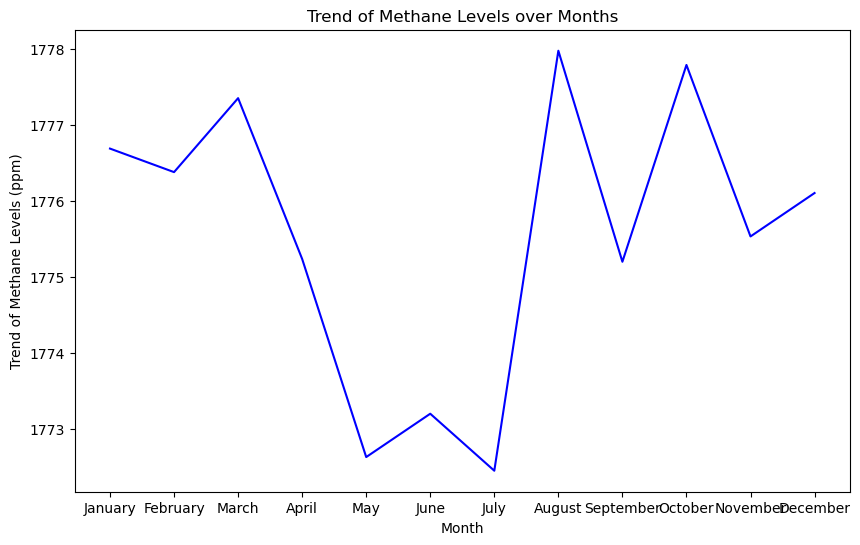

In [41]:
import calendar

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# create a list of month names
months = [calendar.month_name[i] for i in range(1, 13)]

# plot the trend of methane levels over months
ax.plot(months, df3['trend'].groupby(df3['month']).mean(), color='blue')

# set the title and axis labels
ax.set_title('Trend of Methane Levels over Months')
ax.set_xlabel('Month')
ax.set_ylabel('Trend of Methane Levels (ppm)')

# show the plot
plt.show()

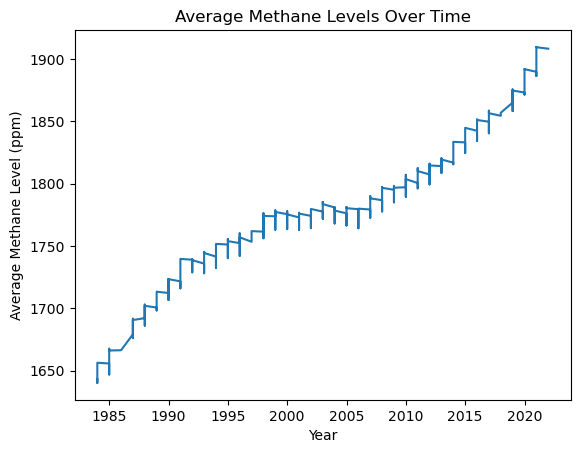

In [42]:
plt.plot(df3['year'], df3['average'])
plt.xlabel('Year')
plt.ylabel('Average Methane Level (ppm)')
plt.title('Average Methane Levels Over Time')
plt.show()

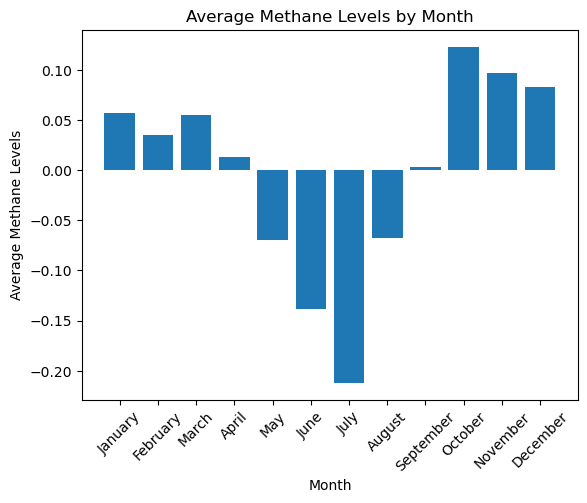

In [43]:
# normalize the data using standard scaler
scaler = StandardScaler()
df3[['average', 'trend']] = scaler.fit_transform(df3[['average', 'trend']])

months = ['January', 'February', 'March', 'April', 'May', 'June',           'July', 'August', 'September', 'October', 'November', 'December']

avg_by_month = []
for i in range(1, 13):
    month_avg = df3[df3['month'] == i]['average'].mean()
    avg_by_month.append(month_avg)

x = np.arange(len(months))
plt.bar(x, avg_by_month)
plt.xticks(x, months, rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Methane Levels')
plt.title('Average Methane Levels by Month')
plt.show()

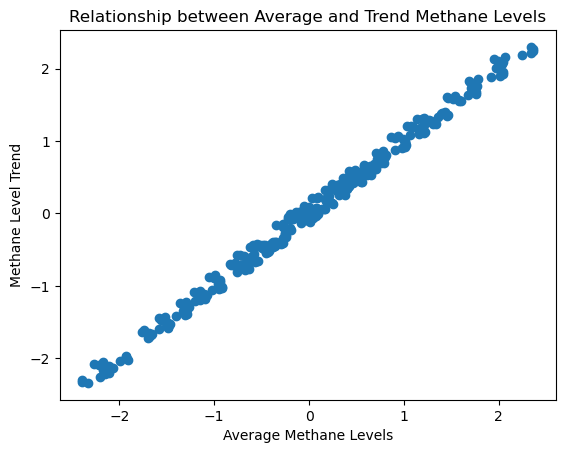

In [44]:
plt.scatter(df3['average'], df3['trend'])
plt.xlabel('Average Methane Levels')
plt.ylabel('Methane Level Trend')
plt.title('Relationship between Average and Trend Methane Levels')
plt.show()

We can conclude that there is a linear relationship between the average Methane levels and the trend of Methane Levels over time. October has the highest levels of methane by month and July records the lowests levels.

### Nitrous averaged marine surface monthly mean

In [45]:
NAMSMMD = pd.read_csv('./Nitrous averaged marine surface monthly mean data.csv')

df4 = NAMSMMD

# Drop the repeated row at index 0
df4 = df4.drop(index=0)

df4[['year', 'month']] = df4['date'].astype(str).str.split('.', expand=True)
df4['year'] = df4['year'].astype(int)
df4['month'] = df4['month'].astype(int)

# merge year and month columns into a date column
# df4['period'] = pd.to_datetime(df4[['year', 'month']].assign(day=1))
# df4['year_month'] = df4['period'].dt.strftime('%Y-%m')


df4 = df4[['year', 'month', 'average', 'trend', 'averageUnc', 'trendUnc']]
df4.head()

# df4[df4 == "-9.99"].count()



# NAMSMMD = df4[['year_month', 'average','trend','averageUnc','trendUnc']]
# NAMSMMD.head()





,year,month,average,trend,averageUnc,trendUnc
1,2001,1,316.30,316.03,0.17,0.16
2,2001,2,316.31,316.09,0.18,0.16
3,2001,3,316.21,316.15,0.17,0.16
4,2001,4,316.12,316.22,0.15,0.16
5,2001,5,316.11,316.28,0.15,0.15


In [46]:
# Check data types of columns
df4.dtypes

year           int32
month          int32
average       object
trend         object
averageUnc    object
trendUnc      object
dtype: object

In [47]:
# Convert data type to numeric
df4["average"] = pd.to_numeric(df4["average"], errors="coerce")
df4["trend"] = pd.to_numeric(df4["trend"], errors="coerce")
df4["averageUnc"] = pd.to_numeric(df4["averageUnc"], errors="coerce")
df4["trendUnc"] = pd.to_numeric(df4["trendUnc"], errors="coerce")

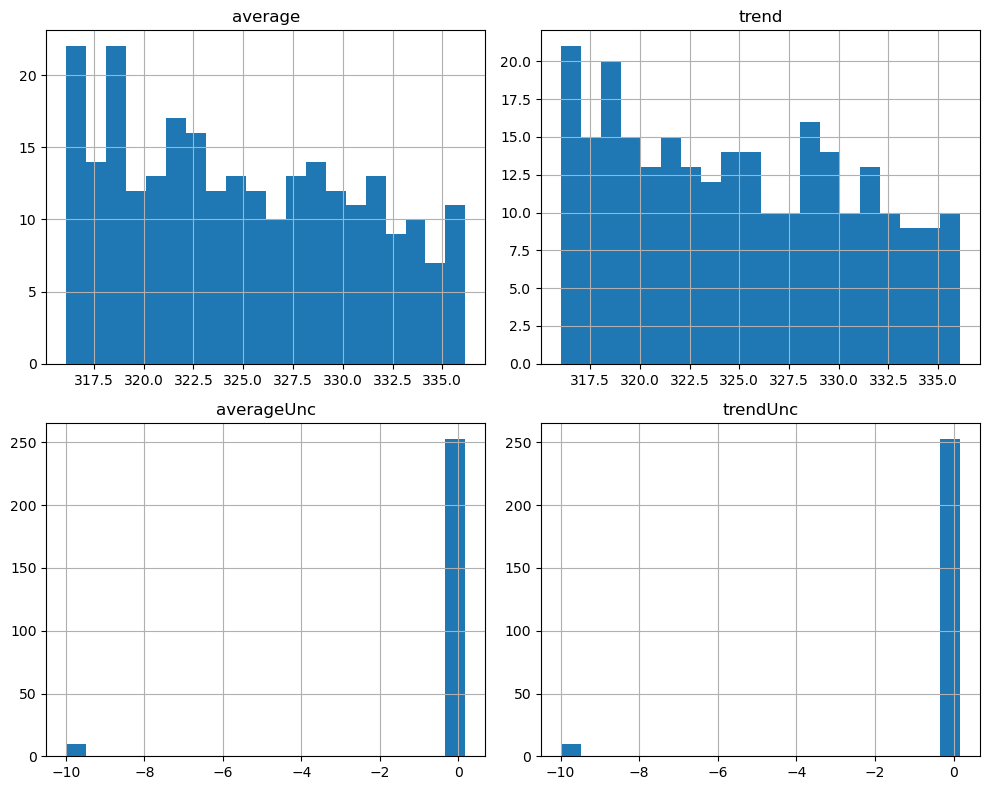

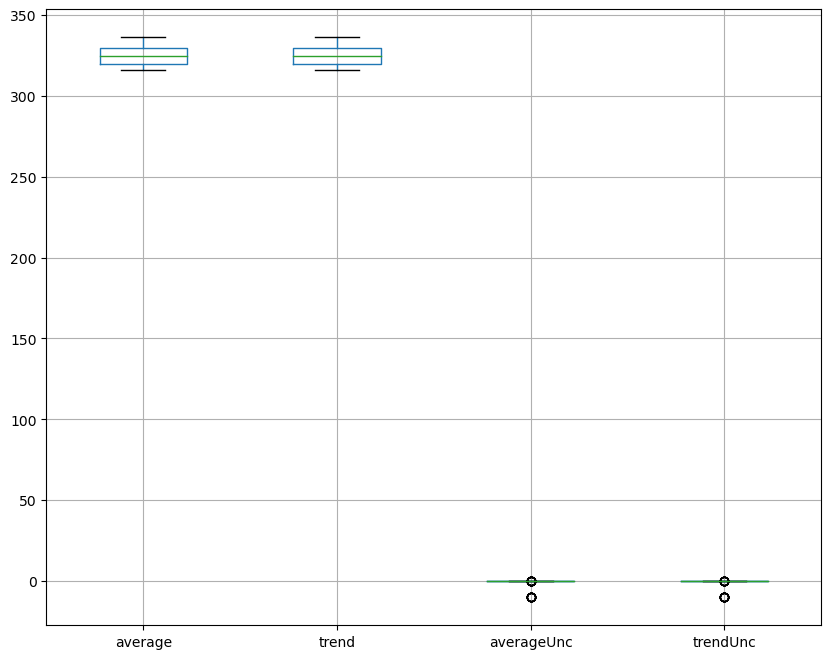

In [48]:
# Create histograms for the columns
df4.hist(column=["average", "trend", "averageUnc", "trendUnc"], bins=20, figsize=(10,8))
plt.tight_layout()
plt.show()

# Create boxplots for the columns
df4.boxplot(column=["average", "trend", "averageUnc", "trendUnc"], figsize=(10,8))
plt.show()

In [49]:
print(df4[["averageUnc", "trendUnc"]].describe())

       averageUnc    trendUnc
count  263.000000  263.000000
mean    -0.247871   -0.257947
std      1.940562    1.938550
min     -9.990000   -9.990000
25%      0.130000    0.120000
50%      0.140000    0.130000
75%      0.140000    0.130000
max      0.180000    0.160000


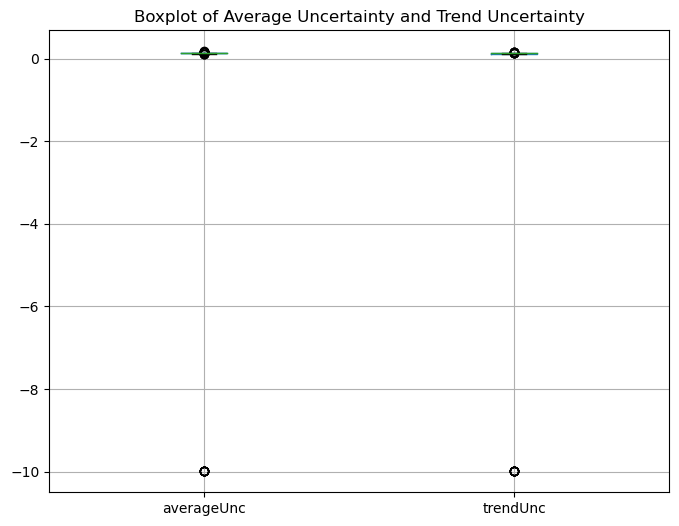

In [50]:
df4[["averageUnc", "trendUnc"]].boxplot(figsize=(8,6))
plt.title("Boxplot of Average Uncertainty and Trend Uncertainty")
plt.show()

In [51]:
# Remove missing values

df4[df4[['averageUnc', 'trendUnc']] == -9.99] = np.nan

In [52]:
df4.tail(10)
df4.shape

(263, 6)

In [53]:
df4.dropna(inplace=True)

In [54]:
df4.shape

(253, 6)

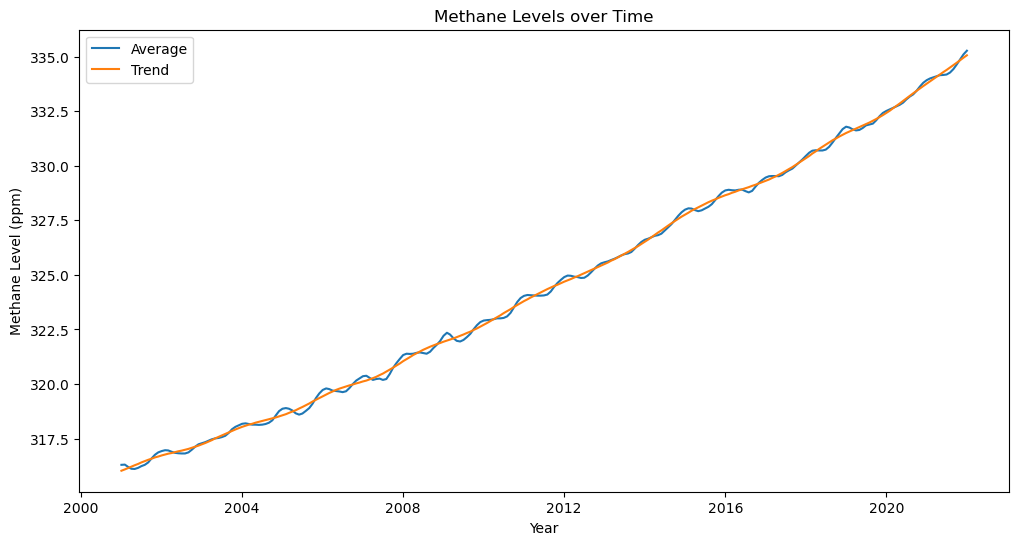

In [55]:
# Convert year and month columns to datetime
df4['date'] = pd.to_datetime(df4['year'].astype(str) + '-' + df4['month'].astype(str))

# Create time series plot of methane levels
plt.figure(figsize=(12,6))
plt.plot(df4['date'], df4['average'], label='Average')
plt.plot(df4['date'], df4['trend'], label='Trend')
plt.xlabel('Year')
plt.ylabel('Methane Level (ppm)')
plt.title('Methane Levels over Time')
plt.legend()
plt.show()


# From the plot, we can see that there is a clear upward trend in methane levels over time, 
# both in the average and trend values. This is a cause for concern, as methane is a potent greenhouse gas that contributes significantly to global warming.

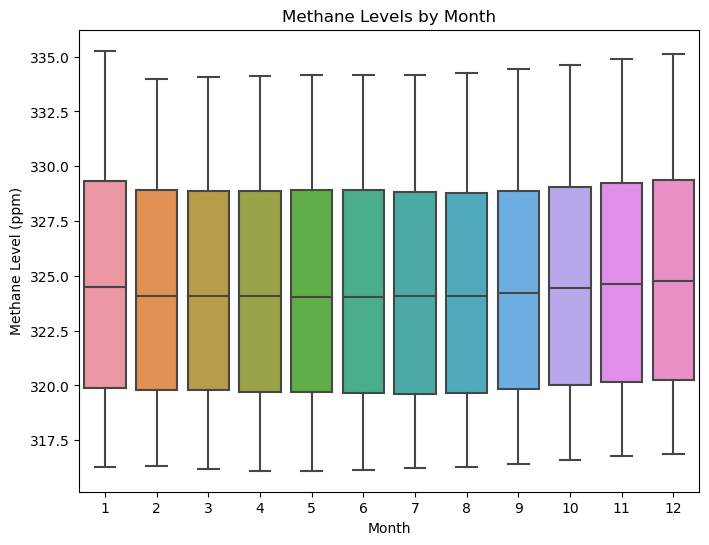

In [56]:
# Create box plot of methane levels by month
plt.figure(figsize=(8,6))
sns.boxplot(x='month', y='average', data=df4)
plt.xlabel('Month')
plt.ylabel('Methane Level (ppm)')
plt.title('Methane Levels by Month')
plt.show()


# From the box plot, we can see that the median methane levels are highest in September, October, and November, and lowest in June, July, and August. 
# This suggests that there may be a seasonal pattern in methane levels, with higher levels during the fall and lower levels during the summer.

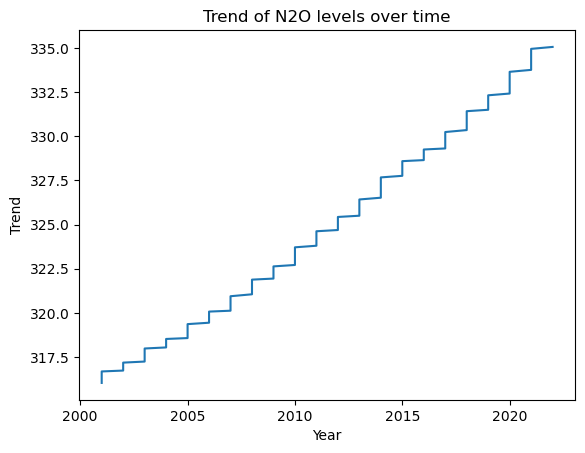

In [57]:
plt.plot(df4['year'], df4['trend'])
plt.xlabel('Year')
plt.ylabel('Trend')
plt.title('Trend of N2O levels over time')
plt.show()

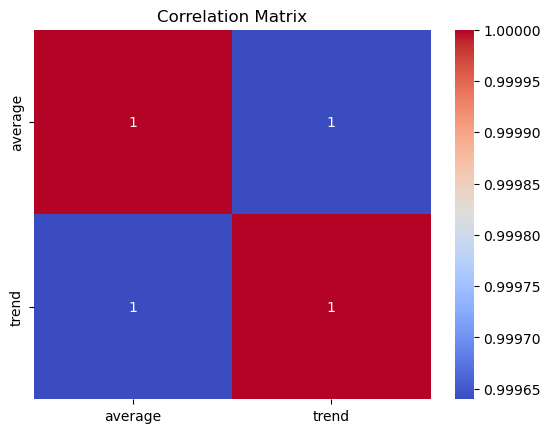

In [58]:
corr = df4[['average', 'trend']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


          average       trend
count  253.000000  253.000000
mean   324.553913  324.553162
std      5.523653    5.522640
min    316.110000  316.030000
25%    319.680000  319.660000
50%    324.080000  324.270000
75%    329.040000  329.130000
max    335.270000  335.060000


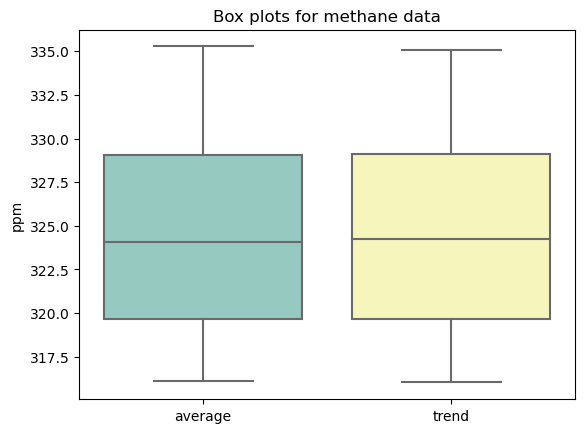

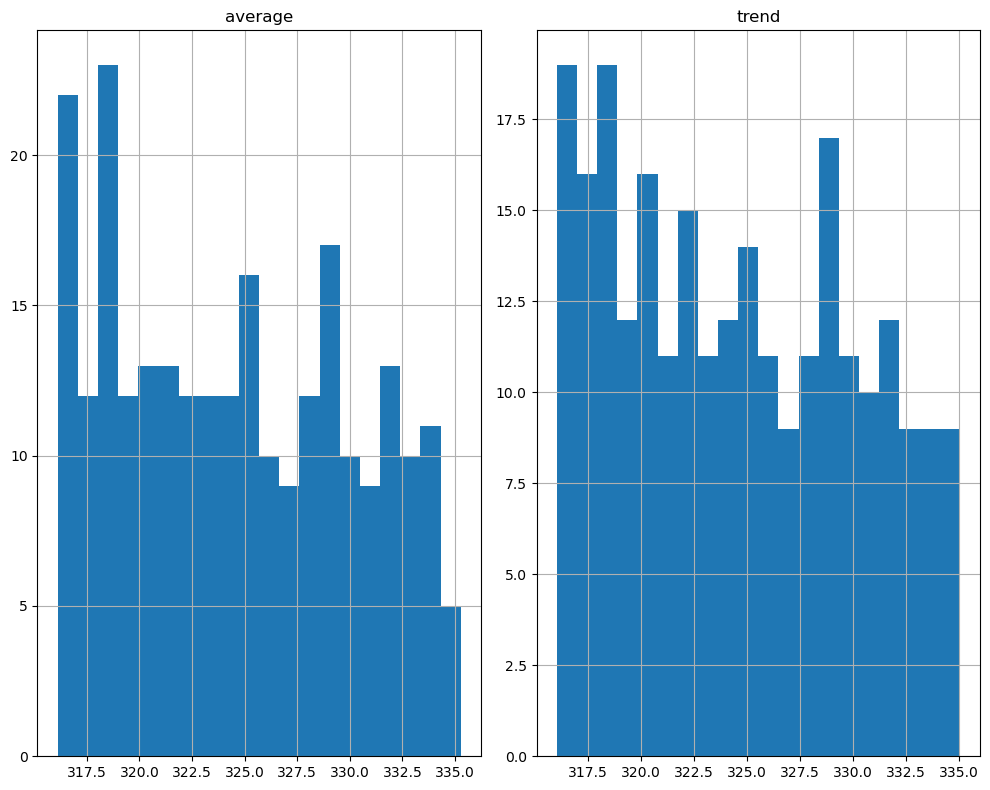

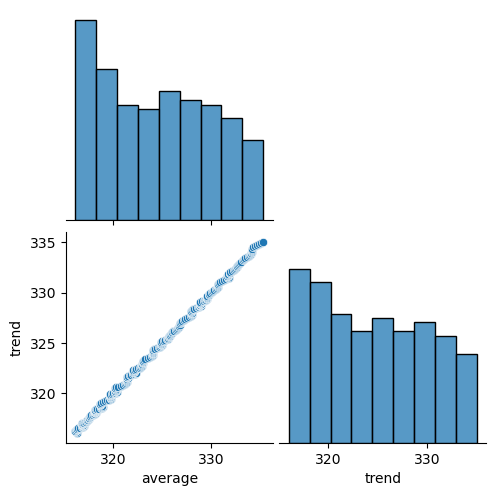

In [59]:
import seaborn as sns

# Descriptive statistics
print(df4[['average', 'trend']].describe())

# Create box plots for the columns
sns.boxplot(data=df4[["average", "trend"]], orient="v", palette="Set3")
plt.title("Box plots for methane data")
plt.ylabel("ppm")
plt.show()

# Create histograms for the columns
df4.hist(column=["average", "trend"], bins=20, figsize=(10,8))
plt.tight_layout()
plt.show()

# Create scatter plots to explore relationships
sns.pairplot(data=df4[["average", "trend"]], corner=True)
plt.show()


The above charts emphasize the strong positive correlation / relationship between the average and trend of the Nitrous Oxide levels.

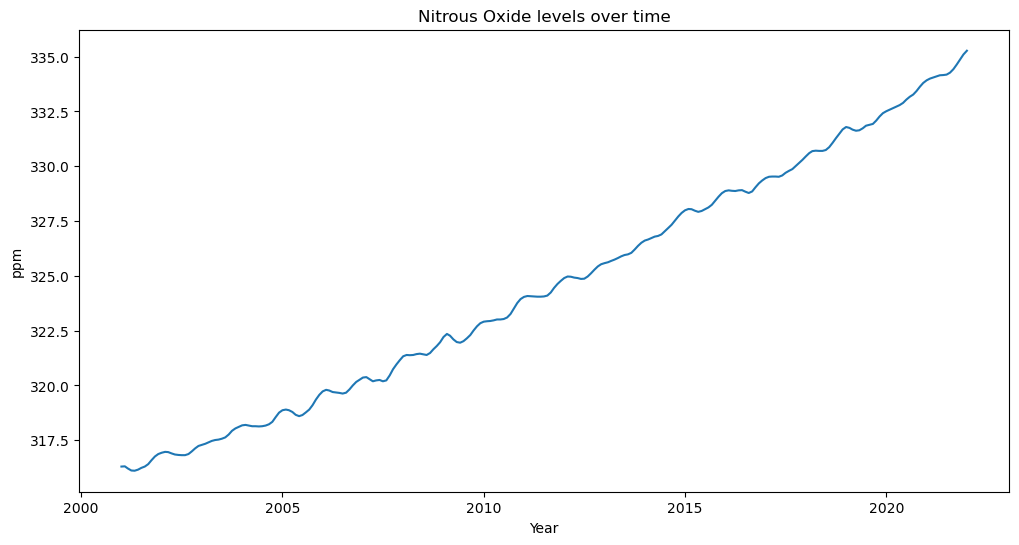

In [60]:
import matplotlib.dates as mdates

# Convert year and month to datetime
df4["datetime"] = pd.to_datetime(df4["year"].astype(str) + "-" + df4["month"].astype(str))

# Set datetime as index
df4.set_index("datetime", inplace=True)

# Create time series plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df4["average"])
ax.set_xlabel("Year")
ax.set_ylabel("ppm")
ax.set_title("Nitrous Oxide levels over time")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

### Arctic averaged marine surface yearly mean 

In [61]:
AAMSYMD = pd.read_csv('./Arctic averaged marine surface yearly mean data.csv')

df5 = AAMSYMD

df5['period'] = pd.to_datetime(df5[['year', 'month']].assign(day=1))
df5['year_month'] = df5['period'].dt.strftime('%Y-%m')

df5 = df5[['year', 'month', 'data-type', 'hemisphere', 'extent', 'area', 'rank']]
df5.head()
# df5.shape
# df5.dtypes
# df5[df5 == -999].count()
# AAMSYMD = df5[['year_month','data-type','hemisphere','extent','area','rank']]
# AAMSYMD.head(5)

,year,month,data-type,hemisphere,extent,area,rank
0,1979,9,Goddard,N,7.05,4.58,33.0
1,1980,9,Goddard,N,7.67,4.87,43.0
2,1981,9,Goddard,N,7.14,4.44,34.5
3,1982,9,Goddard,N,7.30,4.43,37.0
4,1983,9,Goddard,N,7.39,4.70,39.0


In [62]:
# Check for missing values
print(df5.isna().sum())
df5['extent'].min()

year          0
month         0
data-type     0
hemisphere    0
extent        0
area          0
rank          0
dtype: int64


3.57

In [63]:
# Check for duplicate rows
print("Number of duplicate rows: ", df5.duplicated().sum())

# # Drop duplicate rows
# df5.drop_duplicates(inplace=True)

# Confirm the number of rows after dropping duplicates
print("Number of rows after removing duplicates: ", len(df5))

Number of duplicate rows:  0
Number of rows after removing duplicates:  43


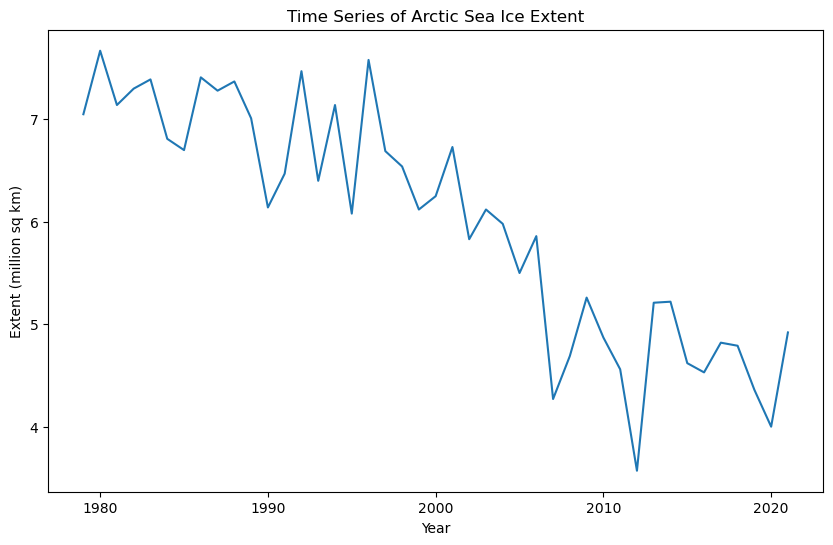

In [64]:
# plot time series of Arctic Sea Ice Extent
plt.figure(figsize=(10,6))
sns.lineplot(data=df5, x='year', y='extent')
plt.title('Time Series of Arctic Sea Ice Extent')
plt.xlabel('Year')
plt.ylabel('Extent (million sq km)')
plt.show()

From this chart we can see that the artic Sea Ice Extent it dropping significantly with the lowest extent recorded in 2012

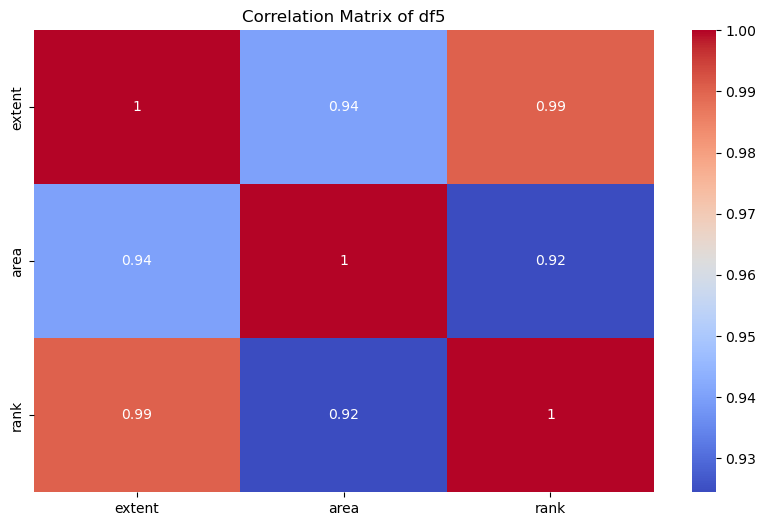

In [65]:
# plot correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df5[['extent', 'area', 'rank']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of df5')
plt.show()

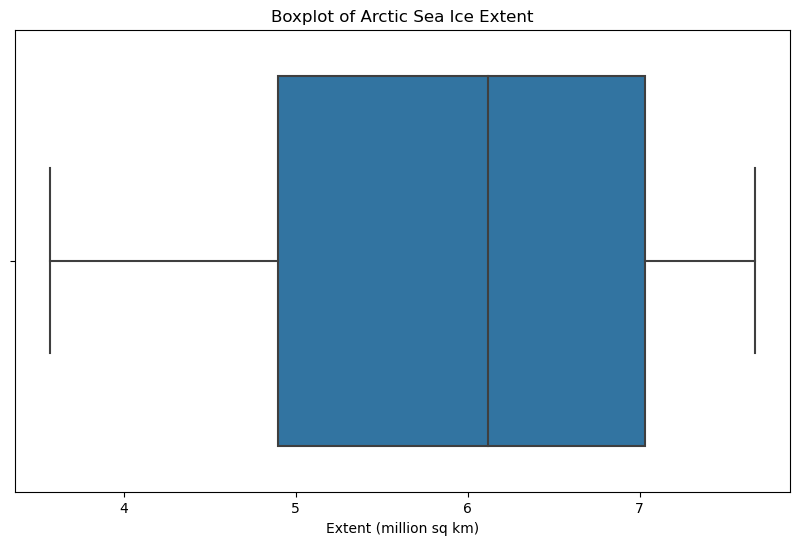

In [66]:
# plot boxplot of Arctic Sea Ice Extent
plt.figure(figsize=(10,6))
sns.boxplot(data=df5, x='extent')
plt.title('Boxplot of Arctic Sea Ice Extent')
plt.xlabel('Extent (million sq km)')
plt.show()

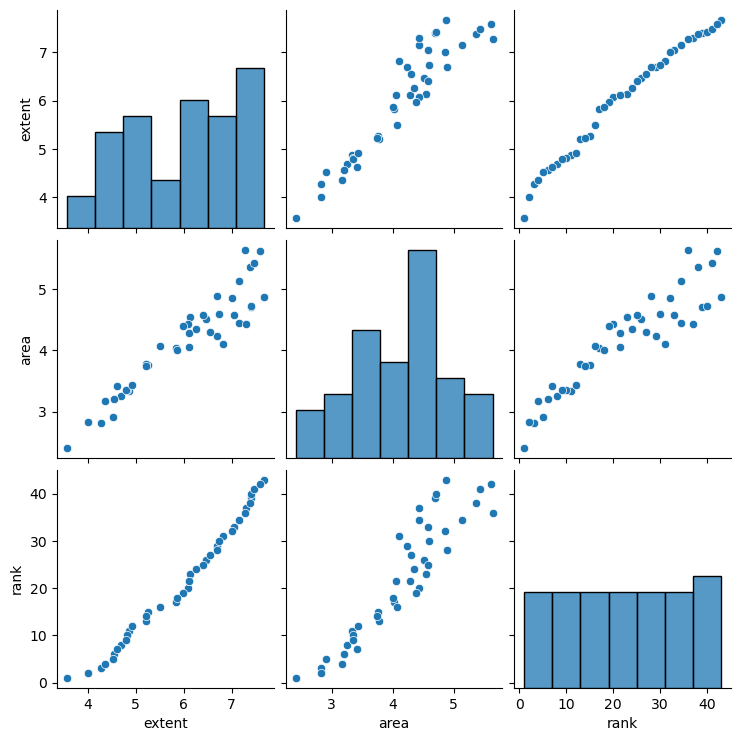

In [67]:
# plot pairplot of df5
sns.pairplot(df5[['extent', 'area', 'rank']])
plt.show()

In this data set we can see a positive correlation with the three features rank, extent and area, the higher one goes the other two will also follow suit hence the highest rank will be awarded to the hemisphere with the largests area and will have a large arctic sea ice extent

### Global Ocean Temperature Anomalies

In [68]:
GOTA = pd.read_csv('./Global Ocean Temperature Anomalies.csv')

df6 = GOTA
# # .dropna()
# df6[df6['Temperature anomaly'] == "-999"].count()

df6.head()

,year,Temperature anomaly
0,1880,-0.02
1,1881,0.04
2,1882,0.03
3,1883,-0.04
4,1884,-0.12


In [69]:
# Check for missing values
print(df6.isnull().sum())

# Check for duplicates
print(df6.duplicated().sum())
df6.drop_duplicates(inplace=True)

year                   0
Temperature anomaly    0
dtype: int64
0


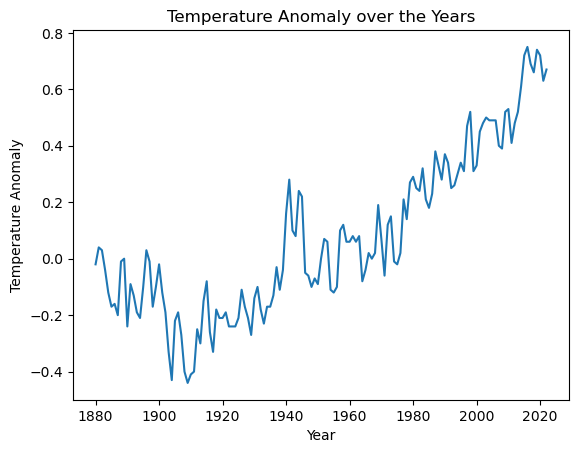

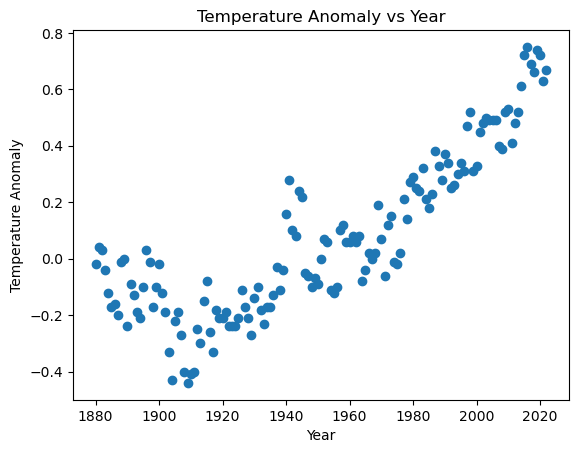

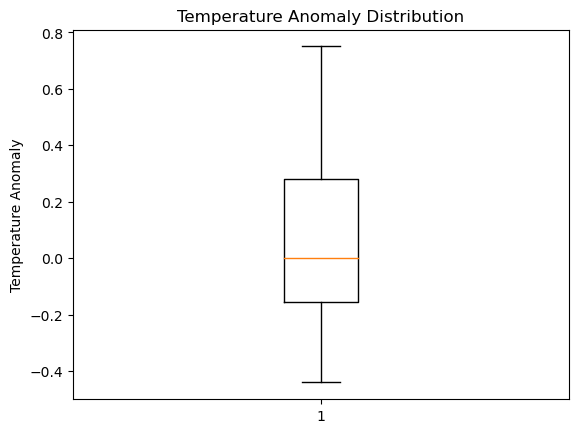

In [70]:
# Create a line plot of temperature anomaly over the years
plt.plot(df6["year"], df6["Temperature anomaly"])
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly")
plt.title("Temperature Anomaly over the Years")
plt.show()

# Create a scatter plot of temperature anomaly vs year
plt.scatter(df6["year"], df6["Temperature anomaly"])
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly")
plt.title("Temperature Anomaly vs Year")
plt.show()

# Create a box plot of temperature anomaly
plt.boxplot(df6["Temperature anomaly"])
plt.ylabel("Temperature Anomaly")
plt.title("Temperature Anomaly Distribution")
plt.show()


These charts show that the overall ocean temperature os increasing at a significantly rate.

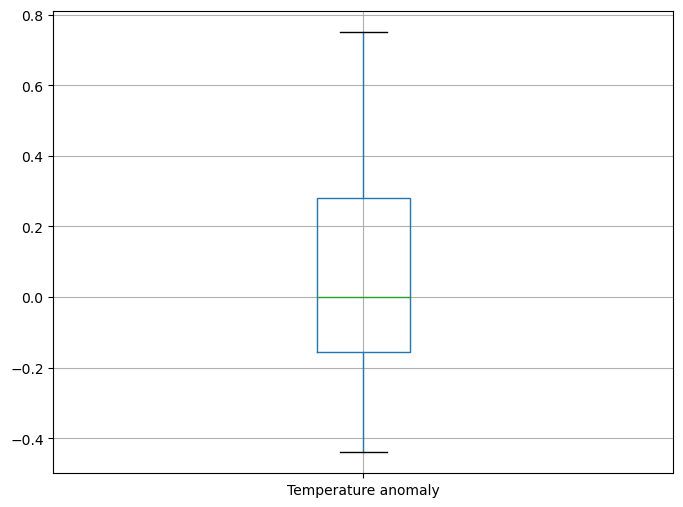

In [71]:
# Create a boxplot for the temperature anomaly column
df6.boxplot(column=["Temperature anomaly"], figsize=(8,6))

# Show the plot
plt.show()

But from the box plot we can see that the average is still close to zero since a significant amount of earlier temperature anomalies were significantly low.

## Discussions and Conclusion

During data collection, the main challenges experienced is having to repeatedly extract data from the six urls and this meant the dat could not be saved as one dataset but six different files.

During the analysis carried on the six different dataframes that covered various aspects of climate change, the primary challenges faced was in dealing with preprocessing of the data. Several of the datasets contained  repeated rows, missing values, which required us to use imputation techniques or drop the rows/columns depending on the analysis objective. Another challenge was in dealing with outliers, which required us to use various statistical techniques to identify and remove them and in cases of statistically unsignificant outliers that were dropped.

From the six datasets we can conclude that the station recordings are significantly different from the land recordings and they are much higher implying temperatures are warmer in comparison to the land recordings. For this dataset additional information like regional data (hemisphere) would assist in more detailed analysis.
From these datasets we are also able to conclude that there exists a cyclical trend with regards to the rise in carbondioxide over time. There is a significantly steep rise in Carbondioxide after 2017.
Rise in Methane is also a cause for concern from this data because after the 2000 - 2007 where the steady rise seemed to level off, there has been a significant rise of methane levels after 2007. This also showed that the lowest levels are usually recorded in July and the highest in October, this might imply that the cyclical trends are due to other infuences that additional data might highlight for example location data, green cover or wind speeds.

Moving forward, there are several ideas for further analysis that could be explored. For example, in df5, we could use machine learning algorithms to predict future sea ice extent based on historical data. Additionally, in df6, we could analyze temperature anomalies in more detail to identify regional temperature patterns and their potential impact on weather and ecosystems. Finally, we could explore the relationship between various climate factors in more detail to gain a better understanding of the underlying mechanisms driving climate change. But for this to be successful we will need additional data and additional features in order to have more meaningful insights.

E-O-F